In [ ]:
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(suppress=True)
from quantile_forest import RandomForestQuantileRegressor
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [2]:
from src.tqf import trans, target_importance_rf

# Data with zero mean

In [3]:
N = 1500
p = 40
np.random.seed(7)
xs = np.random.uniform(-1, 1, size=(N, p)).astype(np.float32)
ys = np.array([np.random.randn() if x < 0. else np.random.randn() * 3 for x in xs[:, 0]])

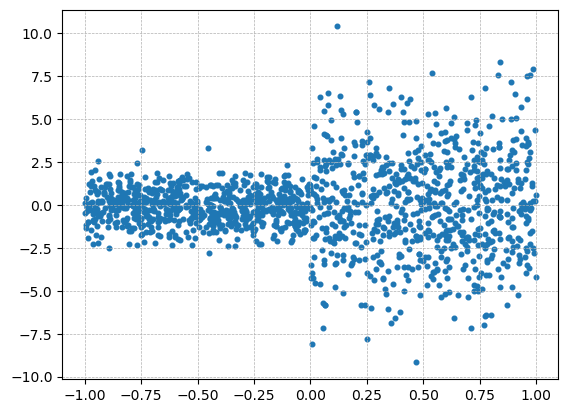

In [4]:
plt.scatter(xs[:, 0], ys, s=11)
plt.grid(ls="--", lw=0.5)

In [5]:
%%time
model = RandomForestQuantileRegressor(n_estimators=100, min_samples_leaf=30, random_state=12)
model.fit(xs, ys)

CPU times: total: 1.78 s
Wall time: 1.8 s


,n_estimators,100
,default_quantiles,0.5
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,30
,max_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0


In [6]:
_dep = np.array([tree.get_depth() for tree in model])
print(_dep.mean(), np.round(_dep.std(), 2))
_leav = np.array([tree.get_n_leaves() for tree in model])
print(_leav.mean(), np.round(_leav.std(), 2))

9.93 1.67
24.49 1.13


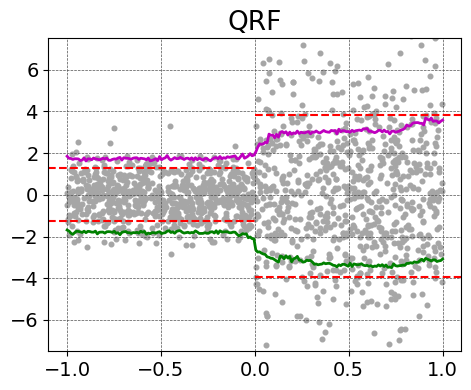

In [7]:
ys_pred_all = []
np.random.seed(0)
for _ in range(100):
    xs_all = np.c_[np.linspace(-1., 1., 200).reshape(-1, 1), np.random.uniform(-1., 1., size=(200, 39))]
    ys_pred = model.predict(xs_all, quantiles=[0.1, 0.9])
    ys_pred_all.append(ys_pred)

ys_pred = np.mean(ys_pred_all, axis=0)

plt.figure(figsize=(5, 4))
plt.title('QRF', fontsize=19)
plt.plot(xs_all[:, 0], ys_pred[:, 0], lw=2, c='g')
plt.plot(xs_all[:, 0], ys_pred[:, 1], lw=2, c='m')
plt.scatter(xs[:, 0], ys, s=11, color=[0.65]*3); plt.ylim(-7.5, 7.5)
plt.grid(ls="--", lw=0.5, c=[0.3]*3)
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.axhline(np.quantile(np.random.randn(10000), q=0.1), 0, 0.5, c='r', ls='--', lw=1.5)
plt.axhline(np.quantile(np.random.randn(10000), q=0.9), 0, 0.5, c='r', ls='--', lw=1.5)
plt.axhline(np.quantile(np.random.randn(10000) * 3, q=0.1), 0.5, 1, c='r', ls='--', lw=1.5)
plt.axhline(np.quantile(np.random.randn(10000) * 3, q=0.9), 0.5, 1, c='r', ls='--', lw=1.5)
plt.tick_params(labelsize=14)
plt.tight_layout()

In [8]:
%%time
model = RandomForestQuantileRegressor(n_estimators=100, min_samples_leaf=30, random_state=12)
_, ys_big = trans(ys, seed=0, T_rff='median')
model.fit(xs, ys_big)

CPU times: total: 1.58 s
Wall time: 1.62 s


,n_estimators,100
,default_quantiles,0.5
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,30
,max_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0


In [9]:
_dep = np.array([tree.get_depth() for tree in model])
print(_dep.mean(), np.round(_dep.std(), 2))
_leav = np.array([tree.get_n_leaves() for tree in model])
print(_leav.mean(), np.round(_leav.std(), 2))

8.32 1.04
24.37 1.07


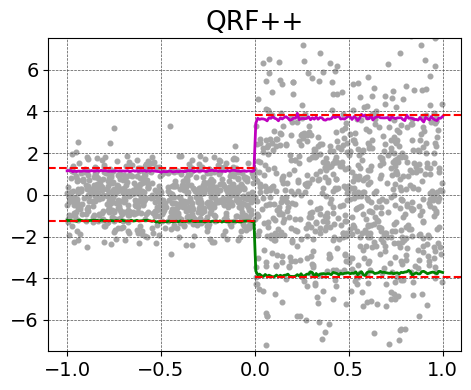

In [10]:
ys_pred_all = []
np.random.seed(0)
for _ in range(100):
    xs_all = np.c_[np.linspace(-1., 1., 200).reshape(-1, 1), np.random.uniform(-1., 1., size=(200, 39))]
    ys_pred = model.predict(xs_all, quantiles=[0.1, 0.9])[:, 0, :]
    ys_pred_all.append(ys_pred)

ys_pred = np.mean(ys_pred_all, axis=0)

plt.figure(figsize=(5, 4))
plt.title('QRF++', fontsize=19)
plt.plot(xs_all[:, 0], ys_pred[:, 0], lw=2, c='g')
plt.plot(xs_all[:, 0], ys_pred[:, 1], lw=2, c='m')
plt.scatter(xs[:, 0], ys, s=11, color=[0.65]*3); plt.ylim(-7.5, 7.5)
plt.grid(ls="--", lw=0.5, c=[0.3]*3)
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.axhline(np.quantile(np.random.randn(10000), q=0.1), 0, 0.5, c='r', ls='--', lw=1.5)
plt.axhline(np.quantile(np.random.randn(10000), q=0.9), 0, 0.5, c='r', ls='--', lw=1.5)
plt.axhline(np.quantile(np.random.randn(10000) * 3, q=0.1), 0.5, 1, c='r', ls='--', lw=1.5)
plt.axhline(np.quantile(np.random.randn(10000) * 3, q=0.9), 0.5, 1, c='r', ls='--', lw=1.5)
plt.tick_params(labelsize=14)
plt.tight_layout()

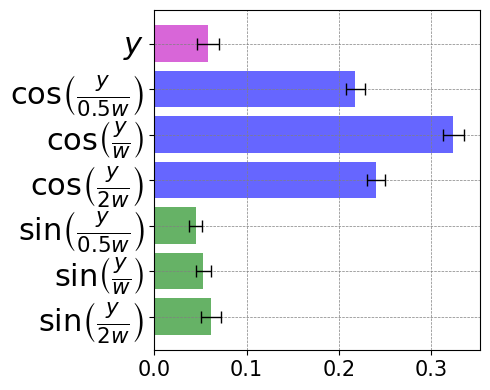

CPU times: total: 453 ms
Wall time: 490 ms


In [ ]:
%%time
ti_mean, ti_std = target_importance_rf(forest=model, X=xs, Y=ys_big)

ypos = np.arange(ys_big.shape[1])

plt.figure(figsize=(5, 4))
errkw = dict(ecolor='k', capsize=4, capthick=1, lw=1)
# y
plt.barh(
    y=ypos[::-1][0], width=ti_mean[0], xerr=ti_std[0],
    color='m', alpha=0.6, error_kw=errkw,
)
# cos
plt.barh(
    y=ypos[::-1][1:4], width=ti_mean[1:4], xerr=ti_std[1:4],
    color='b', alpha=0.6, error_kw=errkw,
)
# sin
plt.barh(
    y=ypos[::-1][4:], width=ti_mean[4:], xerr=ti_std[4:],
    color='g', alpha=0.6, error_kw=errkw,
)

plt.yticks(
    ypos[::-1], labels=[
        r'$y$',
        r'$\cos\!\left(\frac{y}{0.5w}\right)$', r'$\cos\!\left(\frac{y}{w}\right)$', r'$\cos\!\left(\frac{y}{2w}\right)$',
        r'$\sin\!\left(\frac{y}{0.5w}\right)$', r'$\sin\!\left(\frac{y}{w}\right)$', r'$\sin\!\left(\frac{y}{2w}\right)$'
    ],
    fontsize=22
)
plt.xticks([0, 0.1, 0.2, 0.3], fontsize=15)
plt.grid(color='gray', ls='--', lw=0.5)
plt.tight_layout()
plt.show()

In [12]:
def twopeaks(mu: float, size: int | None = None):
    assert 0. < mu < 1.
    sigma = (1 - mu ** 2) ** 0.5
    data = np.random.choice([mu, - mu], size=size) + sigma * np.random.randn(size)
    return data

In [13]:
N = 3000
p = 40
mu = 0.95
np.random.seed(20)
xs = np.random.uniform(-1, 1, size=(N, p)).astype(np.float32)
ys = np.array([np.random.randn() if x < 0. else 
               twopeaks(mu=mu, size=1).item() for x in xs[:, 0]])
ys -= np.mean(ys)

(-3.0, 3.0)

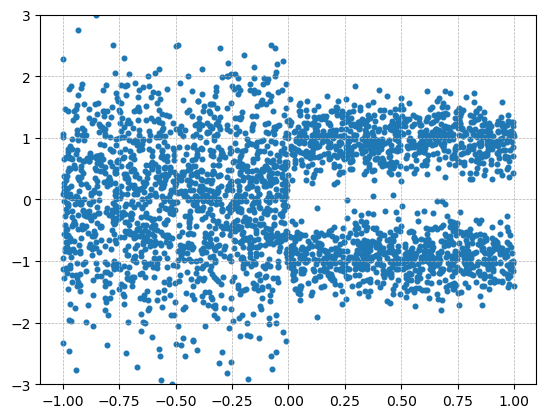

In [14]:
plt.scatter(xs[:, 0], ys, s=11)
plt.grid(ls="--", lw=0.5)
plt.ylim(-3, 3)

In [15]:
%%time
model = RandomForestQuantileRegressor(n_estimators=100, min_samples_leaf=30, random_state=12)
model.fit(xs, ys)

CPU times: total: 6.61 s
Wall time: 6.7 s


,n_estimators,100
,default_quantiles,0.5
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,30
,max_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0


In [16]:
_dep = np.array([tree.get_depth() for tree in model])
print(_dep.mean(), np.round(_dep.std(), 2))
_leav = np.array([tree.get_n_leaves() for tree in model])
print(_leav.mean(), np.round(_leav.std(), 2))

13.0 2.33
48.44 1.59


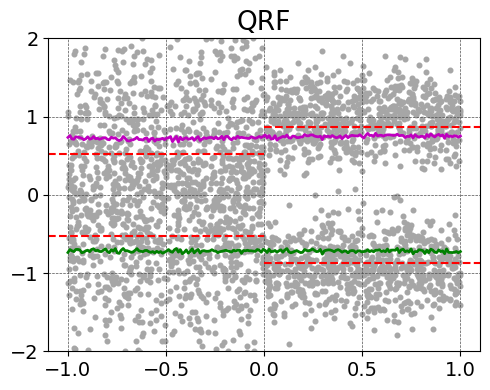

In [17]:
ys_pred_all = []
np.random.seed(0)
for _ in range(100):
    xs_all = np.c_[np.linspace(-1., 1., 200).reshape(-1, 1), np.random.uniform(-1., 1., size=(200, 39))]
    ys_pred = model.predict(xs_all, quantiles=[0.3, 0.7])
    ys_pred_all.append(ys_pred)

ys_pred = np.mean(ys_pred_all, axis=0)

plt.figure(figsize=(5, 4))
plt.title('QRF', fontsize=19)
plt.plot(xs_all[:, 0], ys_pred[:, 0], lw=2, c='g')
plt.plot(xs_all[:, 0], ys_pred[:, 1], lw=2, c='m')
plt.scatter(xs[:, 0], ys, s=11, color=[0.65]*3); plt.ylim(-2, 2)
plt.grid(ls="--", lw=0.5, c=[0.3]*3)
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.yticks([-2, -1, 0, 1, 2])
plt.axhline(np.quantile(np.random.randn(10000), q=0.3), 0, 0.5, c='r', ls='--', lw=1.5)
plt.axhline(np.quantile(np.random.randn(10000), q=0.7), 0, 0.5, c='r', ls='--', lw=1.5)
plt.axhline(np.quantile(twopeaks(size=10000, mu=mu), q=0.3), 0.5, 1, c='r', ls='--', lw=1.5)
plt.axhline(np.quantile(twopeaks(size=10000, mu=mu), q=0.7), 0.5, 1, c='r', ls='--', lw=1.5)
plt.tick_params(labelsize=14)
plt.tight_layout()

In [18]:
%%time
model = RandomForestQuantileRegressor(n_estimators=100, min_samples_leaf=30, random_state=12)
_, ys_big = trans(ys, seed=0, T_rff='median')
model.fit(xs, ys_big)

CPU times: total: 6.41 s
Wall time: 6.6 s


,n_estimators,100
,default_quantiles,0.5
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,30
,max_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0


In [19]:
_dep = np.array([tree.get_depth() for tree in model])
print(_dep.mean(), np.round(_dep.std(), 2))
_leav = np.array([tree.get_n_leaves() for tree in model])
print(_leav.mean(), np.round(_leav.std(), 2))

11.31 1.4
48.57 1.5


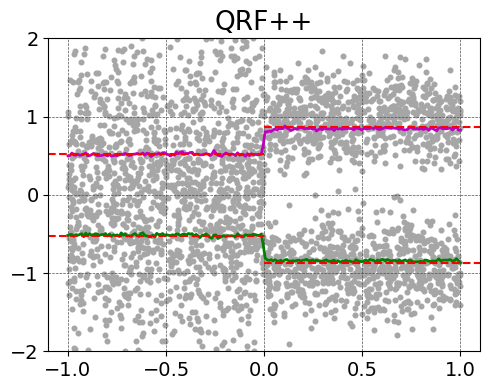

In [20]:
ys_pred_all = []
np.random.seed(0)
for _ in range(100):
    xs_all = np.c_[np.linspace(-1., 1., 200).reshape(-1, 1), np.random.uniform(-1., 1., size=(200, 39))]
    ys_pred = model.predict(xs_all, quantiles=[0.3, 0.7])[:, 0, :]
    ys_pred_all.append(ys_pred)

ys_pred = np.mean(ys_pred_all, axis=0)

plt.figure(figsize=(5, 4))
plt.title('QRF++', fontsize=19)
plt.plot(xs_all[:, 0], ys_pred[:, 0], lw=2, c='g')
plt.plot(xs_all[:, 0], ys_pred[:, 1], lw=2, c='m')
plt.scatter(xs[:, 0], ys, s=11, color=[0.65]*3); plt.ylim(-2, 2)
plt.grid(ls="--", lw=0.5, c=[0.3]*3)
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.yticks([-2, -1, 0, 1, 2])
plt.axhline(np.quantile(np.random.randn(10000), q=0.3), 0, 0.5, c='r', ls='--', lw=1.5)
plt.axhline(np.quantile(np.random.randn(10000), q=0.7), 0, 0.5, c='r', ls='--', lw=1.5)
plt.axhline(np.quantile(twopeaks(size=10000, mu=mu), q=0.3), 0.5, 1, c='r', ls='--', lw=1.5)
plt.axhline(np.quantile(twopeaks(size=10000, mu=mu), q=0.7), 0.5, 1, c='r', ls='--', lw=1.5)
plt.tick_params(labelsize=14)
plt.tight_layout()

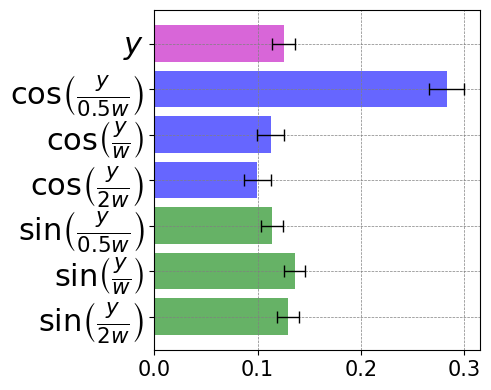

CPU times: total: 1.64 s
Wall time: 1.64 s


In [ ]:
%%time
ti_mean, ti_std = target_importance_rf(forest=model, X=xs, Y=ys_big)

ypos = np.arange(ys_big.shape[1])

plt.figure(figsize=(5, 4))
errkw = dict(ecolor='k', capsize=4, capthick=1, lw=1)
# y
plt.barh(
    y=ypos[::-1][0], width=ti_mean[0], xerr=ti_std[0],
    color='m', alpha=0.6, error_kw=errkw,
)
# cos
plt.barh(
    y=ypos[::-1][1:4], width=ti_mean[1:4], xerr=ti_std[1:4],
    color='b', alpha=0.6, error_kw=errkw,
)
# sin
plt.barh(
    y=ypos[::-1][4:], width=ti_mean[4:], xerr=ti_std[4:],
    color='g', alpha=0.6, error_kw=errkw,
)

plt.yticks(
    ypos[::-1], labels=[
        r'$y$',
        r'$\cos\!\left(\frac{y}{0.5w}\right)$', r'$\cos\!\left(\frac{y}{w}\right)$', r'$\cos\!\left(\frac{y}{2w}\right)$',
        r'$\sin\!\left(\frac{y}{0.5w}\right)$', r'$\sin\!\left(\frac{y}{w}\right)$', r'$\sin\!\left(\frac{y}{2w}\right)$'
    ],
    fontsize=22
)
plt.xticks([0, 0.1, 0.2, 0.3], fontsize=15)
plt.grid(color='gray', ls='--', lw=0.5)
plt.tight_layout()
plt.show()

In [22]:
def funnel(x: float, size: int | None = None):
    assert -1. <= x <= 1.
    data = np.random.uniform(low=-(2.5 + x)**2, high=(2.5 + x)**2, size=size)
    return data

In [23]:
N = 3500
p = 40
np.random.seed(187)
xs = np.random.uniform(-1, 1, size=(N, p)).astype(np.float32)
ys = np.array([funnel(x=x, size=1).item() for x in xs[:, 0]])
ys -= ys.mean()

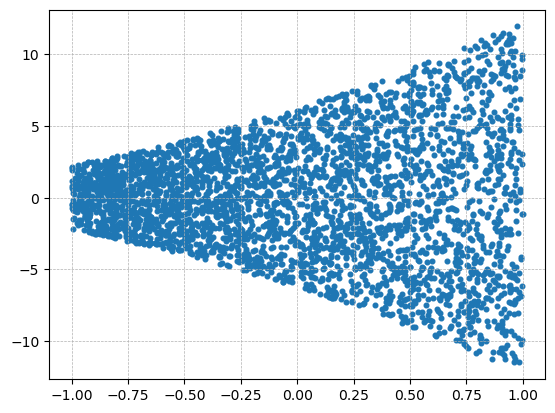

In [24]:
plt.scatter(xs[:, 0], ys, s=11)
plt.grid(ls="--", lw=0.5)

In [25]:
%%time
model = RandomForestQuantileRegressor(n_estimators=100, min_samples_leaf=30, random_state=1)
model.fit(xs, ys)

CPU times: total: 8.12 s
Wall time: 8.25 s


,n_estimators,100
,default_quantiles,0.5
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,30
,max_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0


In [26]:
_dep = np.array([tree.get_depth() for tree in model])
print(_dep.mean(), np.round(_dep.std(), 2))
_leav = np.array([tree.get_n_leaves() for tree in model])
print(_leav.mean(), np.round(_leav.std(), 2))

13.45 2.48
56.65 1.65


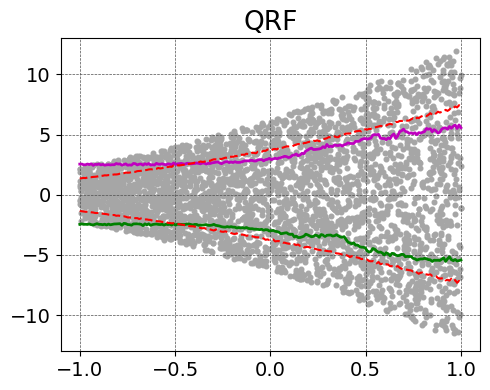

In [27]:
ys_pred_all = []
np.random.seed(0)
for _ in range(100):
    xs_all = np.c_[np.linspace(-1., 1., 200).reshape(-1, 1), np.random.uniform(-1., 1., size=(200, xs.shape[1] - 1))]
    ys_pred = model.predict(xs_all, quantiles=[0.2, 0.8])
    ys_pred_all.append(ys_pred)

ys_pred = np.mean(ys_pred_all, axis=0)

plt.figure(figsize=(5, 4))
plt.title('QRF', fontsize=19)
plt.plot(xs_all[:, 0], ys_pred[:, 0], lw=2, c='g')
plt.plot(xs_all[:, 0], ys_pred[:, 1], lw=2, c='m')
plt.scatter(xs[:, 0], ys, s=11, color=[0.65]*3); plt.ylim(-13, 13)
plt.grid(ls="--", lw=0.5, c=[0.3]*3)
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.plot(xs_all[:, 0], [np.quantile(funnel(x=x, size=20000), q=[0.2, 0.8]) for x in xs_all[:, 0]], c='r', ls='--', lw=1.5)
plt.tick_params(labelsize=14)
plt.tight_layout()

In [28]:
%%time
model = RandomForestQuantileRegressor(n_estimators=100, min_samples_leaf=30, random_state=1)
_, ys_big = trans(ys, seed=0, T_rff='median')
model.fit(xs, ys_big)

CPU times: total: 7.05 s
Wall time: 7.06 s


,n_estimators,100
,default_quantiles,0.5
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,30
,max_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0


In [29]:
_dep = np.array([tree.get_depth() for tree in model])
print(_dep.mean(), np.round(_dep.std(), 2))
_leav = np.array([tree.get_n_leaves() for tree in model])
print(_leav.mean(), np.round(_leav.std(), 2))

10.01 1.18
56.38 1.57


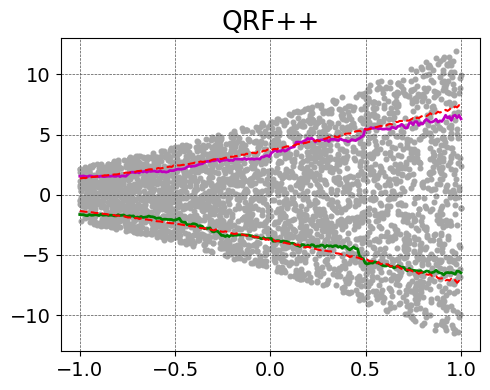

In [30]:
ys_pred_all = []
np.random.seed(0)
for _ in range(100):
    xs_all = np.c_[np.linspace(-1., 1., 200).reshape(-1, 1), np.random.uniform(-1., 1., size=(200, xs.shape[1] - 1))]
    ys_pred = model.predict(xs_all, quantiles=[0.2, 0.8])[:, 0, :]
    ys_pred_all.append(ys_pred)

ys_pred = np.mean(ys_pred_all, axis=0)

plt.figure(figsize=(5, 4))
plt.title('QRF++', fontsize=19)
plt.plot(xs_all[:, 0], ys_pred[:, 0], lw=2, c='g')
plt.plot(xs_all[:, 0], ys_pred[:, 1], lw=2, c='m')
plt.scatter(xs[:, 0], ys, s=11, color=[0.65]*3); plt.ylim(-13, 13)
plt.grid(ls="--", lw=0.5, c=[0.3]*3)
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.plot(xs_all[:, 0], [np.quantile(funnel(x=x, size=20000), q=[0.2, 0.8]) for x in xs_all[:, 0]], c='r', ls='--', lw=1.5)
plt.tick_params(labelsize=14)
plt.tight_layout()

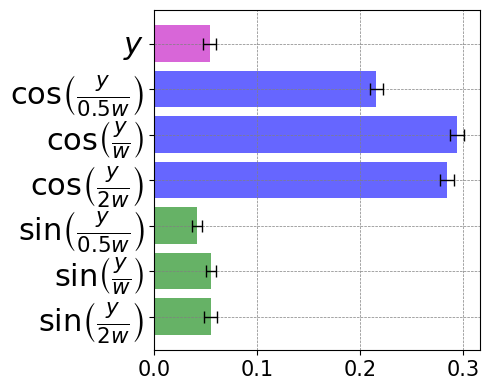

CPU times: total: 1.92 s
Wall time: 1.94 s


In [ ]:
%%time
ti_mean, ti_std = target_importance_rf(forest=model, X=xs, Y=ys_big)

ypos = np.arange(ys_big.shape[1])

plt.figure(figsize=(5, 4))
errkw = dict(ecolor='k', capsize=4, capthick=1, lw=1)
# y
plt.barh(
    y=ypos[::-1][0], width=ti_mean[0], xerr=ti_std[0],
    color='m', alpha=0.6, error_kw=errkw,
)
# cos
plt.barh(
    y=ypos[::-1][1:4], width=ti_mean[1:4], xerr=ti_std[1:4],
    color='b', alpha=0.6, error_kw=errkw,
)
# sin
plt.barh(
    y=ypos[::-1][4:], width=ti_mean[4:], xerr=ti_std[4:],
    color='g', alpha=0.6, error_kw=errkw,
)

plt.yticks(
    ypos[::-1], labels=[
        r'$y$',
        r'$\cos\!\left(\frac{y}{0.5w}\right)$', r'$\cos\!\left(\frac{y}{w}\right)$', r'$\cos\!\left(\frac{y}{2w}\right)$',
        r'$\sin\!\left(\frac{y}{0.5w}\right)$', r'$\sin\!\left(\frac{y}{w}\right)$', r'$\sin\!\left(\frac{y}{2w}\right)$'
    ],
    fontsize=22
)
plt.xticks([0, 0.1, 0.2, 0.3], fontsize=15)
plt.grid(color='gray', ls='--', lw=0.5)
plt.tight_layout()
plt.show()

In [32]:
N = 1700
p = 40
np.random.seed(5)
xs = np.random.uniform(-1, 1, size=(N, p)).astype(np.float32)
ys = np.array([1 - np.random.exponential() if x < 0. else np.random.exponential() - 1 for x in xs[:, 0]])

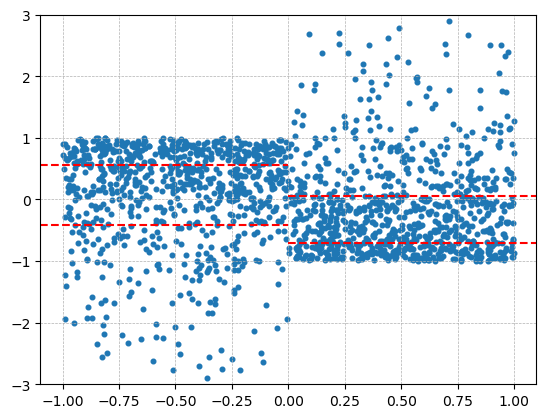

In [33]:
plt.ylim(-3, 3)
plt.scatter(xs[:, 0], ys, s=11)
plt.grid(ls="--", lw=0.5)
plt.axhline(np.quantile(1 - np.random.exponential(size=10000), q=0.65), 0, 0.5, c='r', ls='--')
plt.axhline(np.quantile(np.random.exponential(size=10000) - 1, q=0.65), 0.5, 1, c='r', ls='--')
plt.axhline(np.quantile(1 - np.random.exponential(size=10000), q=0.25), 0, 0.5, c='r', ls='--')
plt.axhline(np.quantile(np.random.exponential(size=10000) - 1, q=0.25), 0.5, 1, c='r', ls='--')

In [34]:
%%time
model = RandomForestQuantileRegressor(n_estimators=100, min_samples_leaf=30, random_state=12)
model.fit(xs, ys)

CPU times: total: 3.19 s
Wall time: 3.21 s


,n_estimators,100
,default_quantiles,0.5
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,30
,max_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0


In [35]:
_dep = np.array([tree.get_depth() for tree in model])
print(_dep.mean(), np.round(_dep.std(), 2))
_leav = np.array([tree.get_n_leaves() for tree in model])
print(_leav.mean(), np.round(_leav.std(), 2))

10.47 1.74
27.71 1.17


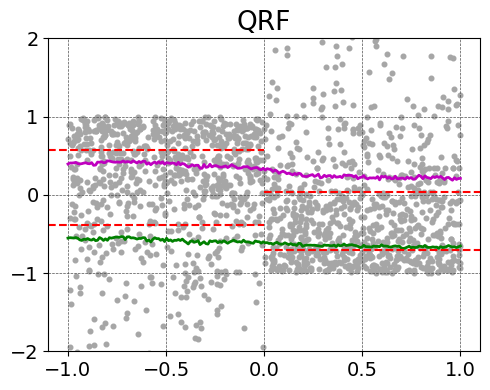

In [36]:
ys_pred_all = []
np.random.seed(0)
for _ in range(100):
    xs_all = np.c_[np.linspace(-1., 1., 200).reshape(-1, 1), np.random.uniform(-1., 1., size=(200, 39))]
    ys_pred = model.predict(xs_all, quantiles=[0.25, 0.65])
    ys_pred_all.append(ys_pred)

ys_pred = np.mean(ys_pred_all, axis=0)

plt.figure(figsize=(5, 4))
plt.title('QRF', fontsize=19)
plt.plot(xs_all[:, 0], ys_pred[:, 0], lw=2, c='g')
plt.plot(xs_all[:, 0], ys_pred[:, 1], lw=2, c='m')
plt.scatter(xs[:, 0], ys, s=11, color=[0.65]*3); plt.ylim(-2, 2)
plt.grid(ls="--", lw=0.5, c=[0.3]*3)
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.yticks([-2, -1, 0, 1, 2])
plt.axhline(np.quantile(1 - np.random.exponential(size=10000), q=0.65), 0, 0.5, c='r', ls='--', lw=1.5)
plt.axhline(np.quantile(np.random.exponential(size=10000) - 1, q=0.65), 0.5, 1, c='r', ls='--', lw=1.5)
plt.axhline(np.quantile(1 - np.random.exponential(size=10000), q=0.25), 0, 0.5, c='r', ls='--', lw=1.5)
plt.axhline(np.quantile(np.random.exponential(size=10000) - 1, q=0.25), 0.5, 1, c='r', ls='--', lw=1.5)
plt.tick_params(labelsize=14)
plt.tight_layout()

In [37]:
%%time
model = RandomForestQuantileRegressor(n_estimators=100, min_samples_leaf=30, random_state=12)
_, ys_big = trans(ys, seed=0, T_rff='median')
model.fit(xs, ys_big)

CPU times: total: 2.91 s
Wall time: 2.96 s


,n_estimators,100
,default_quantiles,0.5
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,30
,max_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0


In [38]:
_dep = np.array([tree.get_depth() for tree in model])
print(_dep.mean(), np.round(_dep.std(), 2))
_leav = np.array([tree.get_n_leaves() for tree in model])
print(_leav.mean(), np.round(_leav.std(), 2))

8.71 1.06
27.86 1.18


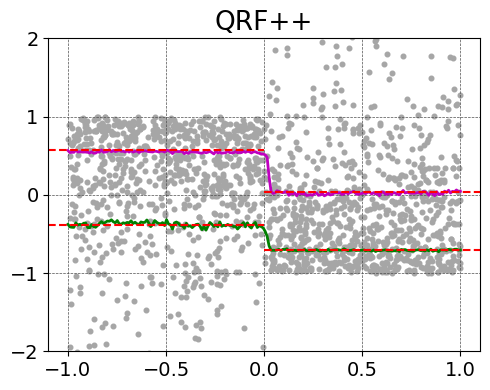

In [39]:
ys_pred_all = []
np.random.seed(0)
for _ in range(100):
    xs_all = np.c_[np.linspace(-1., 1., 200).reshape(-1, 1), np.random.uniform(-1., 1., size=(200, 39))]
    ys_pred = model.predict(xs_all, quantiles=[0.25, 0.65])[:, 0, :]
    ys_pred_all.append(ys_pred)

ys_pred = np.mean(ys_pred_all, axis=0)

plt.figure(figsize=(5, 4))
plt.title('QRF++', fontsize=19)
plt.plot(xs_all[:, 0], ys_pred[:, 0], lw=2, c='g')
plt.plot(xs_all[:, 0], ys_pred[:, 1], lw=2, c='m')
plt.scatter(xs[:, 0], ys, s=11, color=[0.65]*3); plt.ylim(-2, 2)
plt.grid(ls="--", lw=0.5, c=[0.3]*3)
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.yticks([-2, -1, 0, 1, 2])
plt.axhline(np.quantile(1 - np.random.exponential(size=10000), q=0.65), 0, 0.5, c='r', ls='--', lw=1.5)
plt.axhline(np.quantile(np.random.exponential(size=10000) - 1, q=0.65), 0.5, 1, c='r', ls='--', lw=1.5)
plt.axhline(np.quantile(1 - np.random.exponential(size=10000), q=0.25), 0, 0.5, c='r', ls='--', lw=1.5)
plt.axhline(np.quantile(np.random.exponential(size=10000) - 1, q=0.25), 0.5, 1, c='r', ls='--', lw=1.5)
plt.tick_params(labelsize=14)
plt.tight_layout()

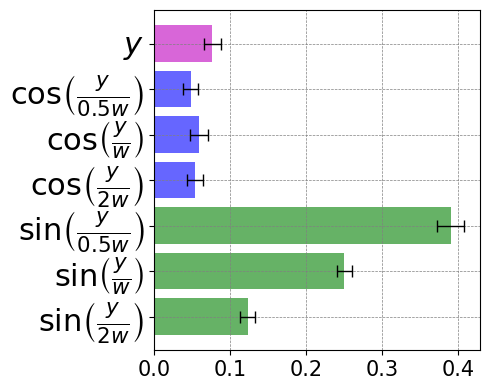

CPU times: total: 859 ms
Wall time: 878 ms


In [ ]:
%%time
ti_mean, ti_std = target_importance_rf(forest=model, X=xs, Y=ys_big)

ypos = np.arange(ys_big.shape[1])

plt.figure(figsize=(5, 4))
errkw = dict(ecolor='k', capsize=4, capthick=1, lw=1)
# y
plt.barh(
    y=ypos[::-1][0], width=ti_mean[0], xerr=ti_std[0],
    color='m', alpha=0.6, error_kw=errkw,
)
# cos
plt.barh(
    y=ypos[::-1][1:4], width=ti_mean[1:4], xerr=ti_std[1:4],
    color='b', alpha=0.6, error_kw=errkw,
)
# sin
plt.barh(
    y=ypos[::-1][4:], width=ti_mean[4:], xerr=ti_std[4:],
    color='g', alpha=0.6, error_kw=errkw,
)

plt.yticks(
    ypos[::-1], labels=[
        r'$y$',
        r'$\cos\!\left(\frac{y}{0.5w}\right)$', r'$\cos\!\left(\frac{y}{w}\right)$', r'$\cos\!\left(\frac{y}{2w}\right)$',
        r'$\sin\!\left(\frac{y}{0.5w}\right)$', r'$\sin\!\left(\frac{y}{w}\right)$', r'$\sin\!\left(\frac{y}{2w}\right)$'
    ],
    fontsize=22
)
plt.xticks([0, 0.1, 0.2, 0.3, 0.4], fontsize=15)
plt.grid(color='gray', ls='--', lw=0.5)
plt.tight_layout()
plt.show()

# Data with nonzero mean

In [41]:
shift_y = 1.0

In [42]:
N = 1500
p = 40
np.random.seed(7)
xs = np.random.uniform(-1, 1, size=(N, p)).astype(np.float32)
ys = np.array([np.random.randn() if x < 0. else np.random.randn() * 3 for x in xs[:, 0]]) + shift_y

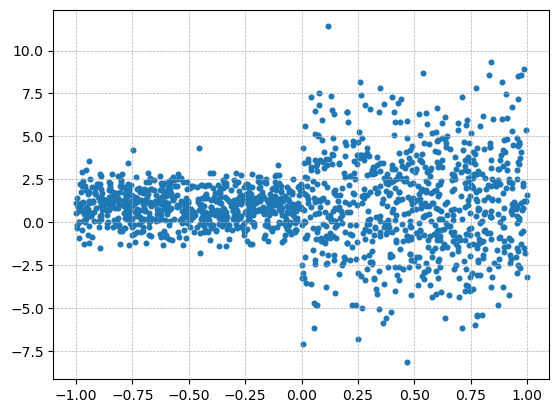

In [43]:
plt.scatter(xs[:, 0], ys, s=11)
plt.grid(ls="--", lw=0.5)

In [44]:
%%time
model = RandomForestQuantileRegressor(n_estimators=100, min_samples_leaf=30, random_state=12)
_, ys_big = trans(ys, seed=0, T_rff='median')
model.fit(xs, ys_big)

CPU times: total: 2.41 s
Wall time: 2.43 s


,n_estimators,100
,default_quantiles,0.5
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,30
,max_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0


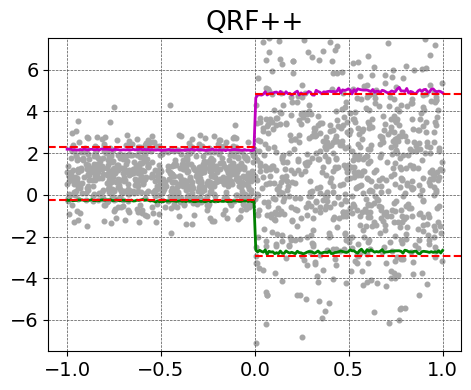

In [45]:
ys_pred_all = []
np.random.seed(0)
for _ in range(100):
    xs_all = np.c_[np.linspace(-1., 1., 200).reshape(-1, 1), np.random.uniform(-1., 1., size=(200, 39))]
    ys_pred = model.predict(xs_all, quantiles=[0.1, 0.9])[:, 0, :]
    ys_pred_all.append(ys_pred)

ys_pred = np.mean(ys_pred_all, axis=0)

plt.figure(figsize=(5, 4))
plt.title('QRF++', fontsize=19)
plt.plot(xs_all[:, 0], ys_pred[:, 0], lw=2, c='g')
plt.plot(xs_all[:, 0], ys_pred[:, 1], lw=2, c='m')
plt.scatter(xs[:, 0], ys, s=11, color=[0.65]*3); plt.ylim(-7.5, 7.5)
plt.grid(ls="--", lw=0.5, c=[0.3]*3)
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.axhline(np.quantile(np.random.randn(10000) + shift_y, q=0.1), 0, 0.5, c='r', ls='--', lw=1.5)
plt.axhline(np.quantile(np.random.randn(10000) + shift_y, q=0.9), 0, 0.5, c='r', ls='--', lw=1.5)
plt.axhline(np.quantile(np.random.randn(10000) * 3 + shift_y, q=0.1), 0.5, 1, c='r', ls='--', lw=1.5)
plt.axhline(np.quantile(np.random.randn(10000) * 3 + shift_y, q=0.9), 0.5, 1, c='r', ls='--', lw=1.5)
plt.tick_params(labelsize=14)
plt.tight_layout()

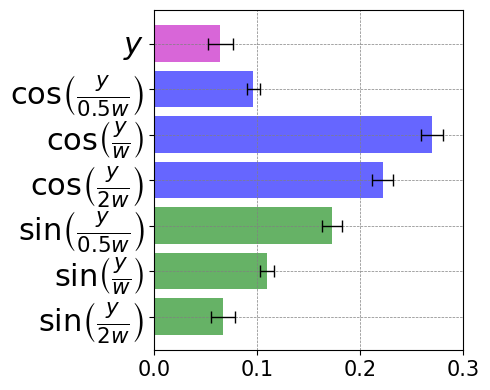

CPU times: total: 750 ms
Wall time: 749 ms


In [ ]:
%%time
ti_mean, ti_std = target_importance_rf(forest=model, X=xs, Y=ys_big)

ypos = np.arange(ys_big.shape[1])

plt.figure(figsize=(5, 4))
errkw = dict(ecolor='k', capsize=4, capthick=1, lw=1)
# y
plt.barh(
    y=ypos[::-1][0], width=ti_mean[0], xerr=ti_std[0],
    color='m', alpha=0.6, error_kw=errkw,
)
# cos
plt.barh(
    y=ypos[::-1][1:4], width=ti_mean[1:4], xerr=ti_std[1:4],
    color='b', alpha=0.6, error_kw=errkw,
)
# sin
plt.barh(
    y=ypos[::-1][4:], width=ti_mean[4:], xerr=ti_std[4:],
    color='g', alpha=0.6, error_kw=errkw,
)

plt.yticks(
    ypos[::-1], labels=[
        r'$y$',
        r'$\cos\!\left(\frac{y}{0.5w}\right)$', r'$\cos\!\left(\frac{y}{w}\right)$', r'$\cos\!\left(\frac{y}{2w}\right)$',
        r'$\sin\!\left(\frac{y}{0.5w}\right)$', r'$\sin\!\left(\frac{y}{w}\right)$', r'$\sin\!\left(\frac{y}{2w}\right)$'
    ],
    fontsize=22
)
plt.xticks([0, 0.1, 0.2, 0.3], fontsize=15)
plt.grid(color='gray', ls='--', lw=0.5)
plt.tight_layout()
plt.show()

In [47]:
def twopeaks(mu: float, size: int | None = None):
    assert 0. < mu < 1.
    sigma = (1 - mu ** 2) ** 0.5
    data = np.random.choice([mu, - mu], size=size) + sigma * np.random.randn(size)
    return data

In [48]:
N = 3000
p = 40
mu = 0.95
np.random.seed(20)
xs = np.random.uniform(-1, 1, size=(N, p)).astype(np.float32)
ys = np.array([np.random.randn() if x < 0. else 
               twopeaks(mu=mu, size=1).item() for x in xs[:, 0]])
ys -= np.mean(ys)
ys += shift_y

(-2.0, 4.0)

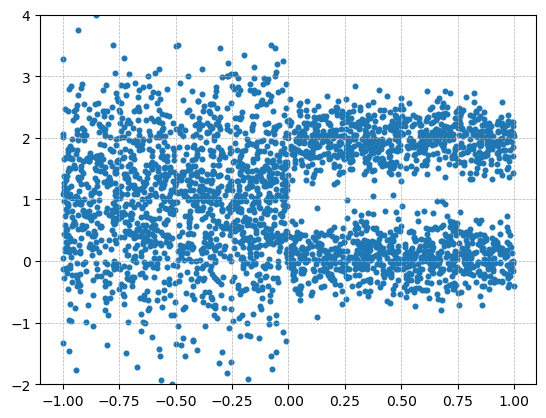

In [49]:
plt.scatter(xs[:, 0], ys, s=11)
plt.grid(ls="--", lw=0.5)
plt.ylim(-2, 4)

In [50]:
%%time
model = RandomForestQuantileRegressor(n_estimators=100, min_samples_leaf=30, random_state=12)
_, ys_big = trans(ys, seed=0, T_rff='median')
model.fit(xs, ys_big)

CPU times: total: 6.33 s
Wall time: 6.42 s


,n_estimators,100
,default_quantiles,0.5
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,30
,max_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0


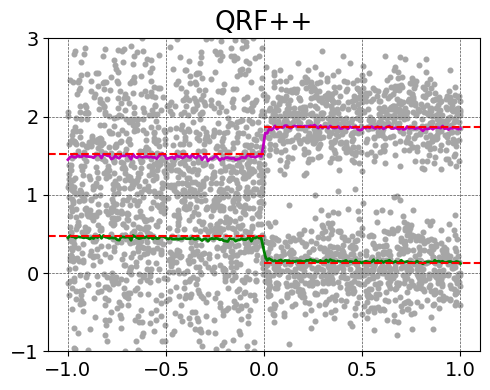

In [51]:
ys_pred_all = []
np.random.seed(0)
for _ in range(100):
    xs_all = np.c_[np.linspace(-1., 1., 200).reshape(-1, 1), np.random.uniform(-1., 1., size=(200, 39))]
    ys_pred = model.predict(xs_all, quantiles=[0.3, 0.7])[:, 0, :]
    ys_pred_all.append(ys_pred)

ys_pred = np.mean(ys_pred_all, axis=0)

plt.figure(figsize=(5, 4))
plt.title('QRF++', fontsize=19)
plt.plot(xs_all[:, 0], ys_pred[:, 0], lw=2, c='g')
plt.plot(xs_all[:, 0], ys_pred[:, 1], lw=2, c='m')
plt.scatter(xs[:, 0], ys, s=11, color=[0.65]*3); plt.ylim(-2 + shift_y, 2 + shift_y)
plt.grid(ls="--", lw=0.5, c=[0.3]*3)
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.yticks([-1, 0, 1, 2, 3])
plt.axhline(np.quantile(np.random.randn(10000), q=0.3) + shift_y, 0, 0.5, c='r', ls='--', lw=1.5)
plt.axhline(np.quantile(np.random.randn(10000), q=0.7) + shift_y, 0, 0.5, c='r', ls='--', lw=1.5)
plt.axhline(np.quantile(twopeaks(size=10000, mu=mu), q=0.3) + shift_y, 0.5, 1, c='r', ls='--', lw=1.5)
plt.axhline(np.quantile(twopeaks(size=10000, mu=mu), q=0.7) + shift_y, 0.5, 1, c='r', ls='--', lw=1.5)
plt.tick_params(labelsize=14)
plt.tight_layout()

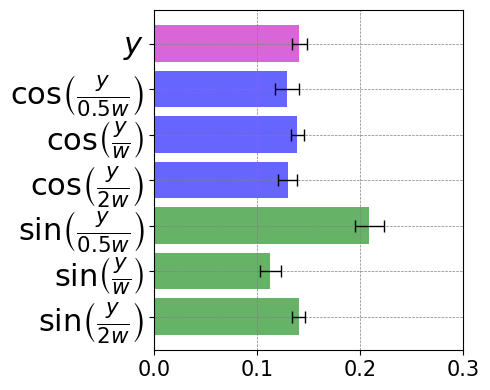

CPU times: total: 1.59 s
Wall time: 1.62 s


In [ ]:
%%time
ti_mean, ti_std = target_importance_rf(forest=model, X=xs, Y=ys_big)

ypos = np.arange(ys_big.shape[1])

plt.figure(figsize=(5, 4))
errkw = dict(ecolor='k', capsize=4, capthick=1, lw=1)
# y
plt.barh(
    y=ypos[::-1][0], width=ti_mean[0], xerr=ti_std[0],
    color='m', alpha=0.6, error_kw=errkw,
)
# cos
plt.barh(
    y=ypos[::-1][1:4], width=ti_mean[1:4], xerr=ti_std[1:4],
    color='b', alpha=0.6, error_kw=errkw,
)
# sin
plt.barh(
    y=ypos[::-1][4:], width=ti_mean[4:], xerr=ti_std[4:],
    color='g', alpha=0.6, error_kw=errkw,
)

plt.yticks(
    ypos[::-1], labels=[
        r'$y$',
        r'$\cos\!\left(\frac{y}{0.5w}\right)$', r'$\cos\!\left(\frac{y}{w}\right)$', r'$\cos\!\left(\frac{y}{2w}\right)$',
        r'$\sin\!\left(\frac{y}{0.5w}\right)$', r'$\sin\!\left(\frac{y}{w}\right)$', r'$\sin\!\left(\frac{y}{2w}\right)$'
    ],
    fontsize=22
)
plt.xticks([0, 0.1, 0.2, 0.3], fontsize=15)
plt.grid(color='gray', ls='--', lw=0.5)
plt.tight_layout()
plt.show()

In [53]:
def funnel(x: float, size: int | None = None):
    assert -1. <= x <= 1.
    data = np.random.uniform(low=-(2.5 + x)**2, high=(2.5 + x)**2, size=size)
    return data

In [54]:
N = 3500
p = 40
np.random.seed(187)
xs = np.random.uniform(-1, 1, size=(N, p)).astype(np.float32)
ys = np.array([funnel(x=x, size=1).item() for x in xs[:, 0]])
ys -= ys.mean()
ys += shift_y

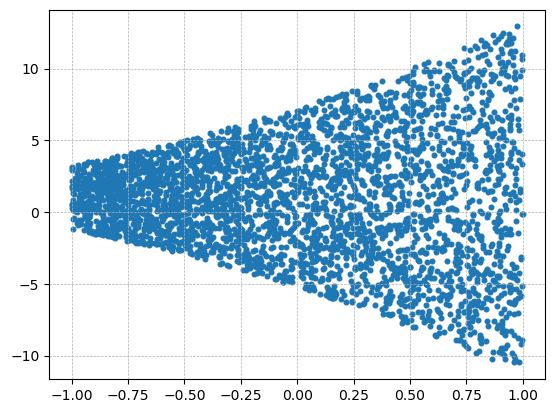

In [55]:
plt.scatter(xs[:, 0], ys, s=11)
plt.grid(ls="--", lw=0.5)

In [56]:
%%time
model = RandomForestQuantileRegressor(n_estimators=100, min_samples_leaf=30, random_state=1)
_, ys_big = trans(ys, seed=0, T_rff='median')
model.fit(xs, ys_big)

CPU times: total: 6.94 s
Wall time: 7.02 s


,n_estimators,100
,default_quantiles,0.5
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,30
,max_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0


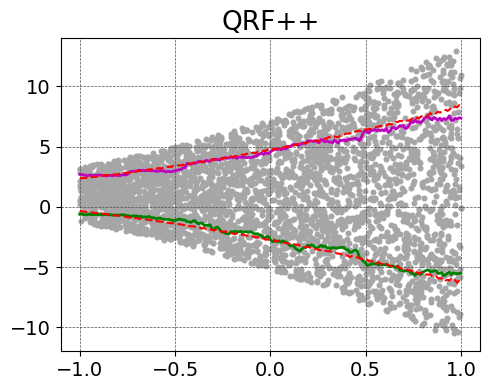

In [57]:
ys_pred_all = []
np.random.seed(0)
for _ in range(100):
    xs_all = np.c_[np.linspace(-1., 1., 200).reshape(-1, 1), np.random.uniform(-1., 1., size=(200, xs.shape[1] - 1))]
    ys_pred = model.predict(xs_all, quantiles=[0.2, 0.8])[:, 0, :]
    ys_pred_all.append(ys_pred)

ys_pred = np.mean(ys_pred_all, axis=0)

plt.figure(figsize=(5, 4))
plt.title('QRF++', fontsize=19)
plt.plot(xs_all[:, 0], ys_pred[:, 0], lw=2, c='g')
plt.plot(xs_all[:, 0], ys_pred[:, 1], lw=2, c='m')
plt.scatter(xs[:, 0], ys, s=11, color=[0.65]*3); plt.ylim(-13 + shift_y, 13 + shift_y)
plt.grid(ls="--", lw=0.5, c=[0.3]*3)
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.plot(xs_all[:, 0], [np.quantile(funnel(x=x, size=20000), q=[0.2, 0.8]) + shift_y for x in xs_all[:, 0]], c='r', ls='--', lw=1.5)
plt.tick_params(labelsize=14)
plt.tight_layout()

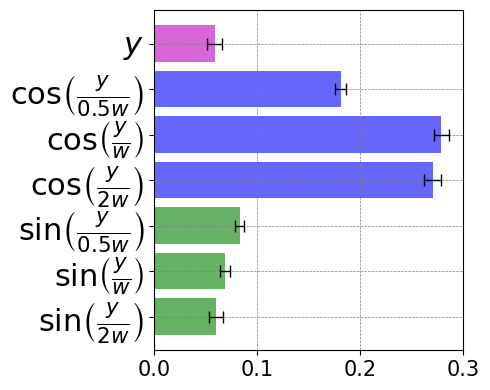

CPU times: total: 1.91 s
Wall time: 1.95 s


In [ ]:
%%time
ti_mean, ti_std = target_importance_rf(forest=model, X=xs, Y=ys_big)

ypos = np.arange(ys_big.shape[1])

plt.figure(figsize=(5, 4))
errkw = dict(ecolor='k', capsize=4, capthick=1, lw=1)
# y
plt.barh(
    y=ypos[::-1][0], width=ti_mean[0], xerr=ti_std[0],
    color='m', alpha=0.6, error_kw=errkw,
)
# cos
plt.barh(
    y=ypos[::-1][1:4], width=ti_mean[1:4], xerr=ti_std[1:4],
    color='b', alpha=0.6, error_kw=errkw,
)
# sin
plt.barh(
    y=ypos[::-1][4:], width=ti_mean[4:], xerr=ti_std[4:],
    color='g', alpha=0.6, error_kw=errkw,
)

plt.yticks(
    ypos[::-1], labels=[
        r'$y$',
        r'$\cos\!\left(\frac{y}{0.5w}\right)$', r'$\cos\!\left(\frac{y}{w}\right)$', r'$\cos\!\left(\frac{y}{2w}\right)$',
        r'$\sin\!\left(\frac{y}{0.5w}\right)$', r'$\sin\!\left(\frac{y}{w}\right)$', r'$\sin\!\left(\frac{y}{2w}\right)$'
    ],
    fontsize=22
)
plt.xticks([0, 0.1, 0.2, 0.3], fontsize=15)
plt.grid(color='gray', ls='--', lw=0.5)
plt.tight_layout()
plt.show()

In [59]:
N = 1700
p = 40
np.random.seed(5)
xs = np.random.uniform(-1, 1, size=(N, p)).astype(np.float32)
ys = np.array([1 - np.random.exponential() if x < 0. else np.random.exponential() - 1 for x in xs[:, 0]]) + shift_y

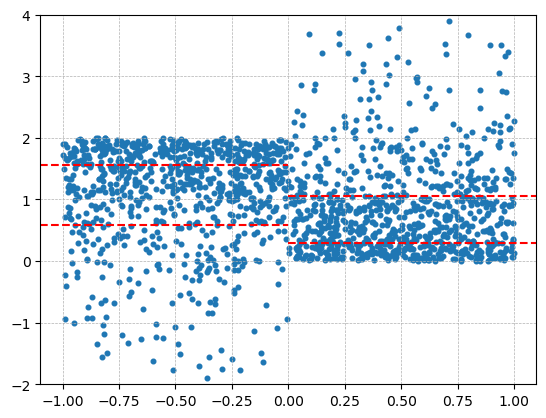

In [60]:
plt.ylim(-3 + shift_y, 3 + shift_y)
plt.scatter(xs[:, 0], ys, s=11)
plt.grid(ls="--", lw=0.5)
plt.axhline(np.quantile(1 - np.random.exponential(size=10000), q=0.65) + shift_y, 0, 0.5, c='r', ls='--')
plt.axhline(np.quantile(np.random.exponential(size=10000) - 1, q=0.65) + shift_y, 0.5, 1, c='r', ls='--')
plt.axhline(np.quantile(1 - np.random.exponential(size=10000), q=0.25) + shift_y, 0, 0.5, c='r', ls='--')
plt.axhline(np.quantile(np.random.exponential(size=10000) - 1, q=0.25) + shift_y, 0.5, 1, c='r', ls='--')

In [61]:
%%time
model = RandomForestQuantileRegressor(n_estimators=100, min_samples_leaf=30, random_state=12)
_, ys_big = trans(ys, seed=0, T_rff='median')
model.fit(xs, ys_big)

CPU times: total: 2.83 s
Wall time: 2.83 s


,n_estimators,100
,default_quantiles,0.5
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,30
,max_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0


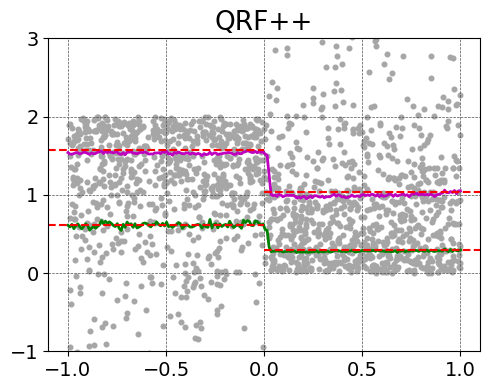

In [62]:
ys_pred_all = []
np.random.seed(0)
for _ in range(100):
    xs_all = np.c_[np.linspace(-1., 1., 200).reshape(-1, 1), np.random.uniform(-1., 1., size=(200, 39))]
    ys_pred = model.predict(xs_all, quantiles=[0.25, 0.65])[:, 0, :]
    ys_pred_all.append(ys_pred)

ys_pred = np.mean(ys_pred_all, axis=0)

plt.figure(figsize=(5, 4))
plt.title('QRF++', fontsize=19)
plt.plot(xs_all[:, 0], ys_pred[:, 0], lw=2, c='g')
plt.plot(xs_all[:, 0], ys_pred[:, 1], lw=2, c='m')
plt.scatter(xs[:, 0], ys, s=11, color=[0.65]*3); plt.ylim(-2 + shift_y, 2 + shift_y)
plt.grid(ls="--", lw=0.5, c=[0.3]*3)
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.yticks([-1, 0, 1, 2, 3])
plt.axhline(np.quantile(1 - np.random.exponential(size=10000), q=0.65) + shift_y, 0, 0.5, c='r', ls='--', lw=1.5)
plt.axhline(np.quantile(np.random.exponential(size=10000) - 1, q=0.65) + shift_y, 0.5, 1, c='r', ls='--', lw=1.5)
plt.axhline(np.quantile(1 - np.random.exponential(size=10000), q=0.25) + shift_y, 0, 0.5, c='r', ls='--', lw=1.5)
plt.axhline(np.quantile(np.random.exponential(size=10000) - 1, q=0.25) + shift_y, 0.5, 1, c='r', ls='--', lw=1.5)
plt.tick_params(labelsize=14)
plt.tight_layout()

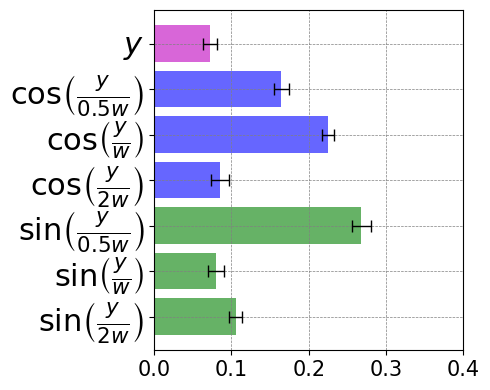

CPU times: total: 828 ms
Wall time: 832 ms


In [ ]:
%%time
ti_mean, ti_std = target_importance_rf(forest=model, X=xs, Y=ys_big)

ypos = np.arange(ys_big.shape[1])

plt.figure(figsize=(5, 4))
errkw = dict(ecolor='k', capsize=4, capthick=1, lw=1)
# y
plt.barh(
    y=ypos[::-1][0], width=ti_mean[0], xerr=ti_std[0],
    color='m', alpha=0.6, error_kw=errkw,
)
# cos
plt.barh(
    y=ypos[::-1][1:4], width=ti_mean[1:4], xerr=ti_std[1:4],
    color='b', alpha=0.6, error_kw=errkw,
)
# sin
plt.barh(
    y=ypos[::-1][4:], width=ti_mean[4:], xerr=ti_std[4:],
    color='g', alpha=0.6, error_kw=errkw,
)

plt.yticks(
    ypos[::-1], labels=[
        r'$y$',
        r'$\cos\!\left(\frac{y}{0.5w}\right)$', r'$\cos\!\left(\frac{y}{w}\right)$', r'$\cos\!\left(\frac{y}{2w}\right)$',
        r'$\sin\!\left(\frac{y}{0.5w}\right)$', r'$\sin\!\left(\frac{y}{w}\right)$', r'$\sin\!\left(\frac{y}{2w}\right)$'
    ],
    fontsize=22
)
plt.xticks([0, 0.1, 0.2, 0.3, 0.4], fontsize=15)
plt.grid(color='gray', ls='--', lw=0.5)
plt.tight_layout()
plt.show()